## Antagonism and Synergy prediction in E. coli

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import sys
import os
from sklearn.preprocessing import label_binarize

sys.path.append('..')
import base.chemgen_utils as utl
import MLmod.predictor_modified as prd

Using TensorFlow backend.


## Cross Validation

In [2]:
drugleg_fname = "../data/chemicals/legend_gramnegpos.txt"
gene_subset = '../data/interaction-genes-Ecoli'
gene_subset = pd.read_csv(gene_subset, header=None)[0].values

In [3]:
X_chemgen = pd.read_csv('../data/chemgenetics/nichols_binarized.csv', index_col=0)
X_chemgen = X_chemgen.iloc[:,np.where(np.isin(X_chemgen.columns, gene_subset))[0]]
targets = pd.read_csv("../data/chemgenetics/nichols_y.csv")
combs = targets['comb'].values
y = targets['type'].values

X_df = pd.DataFrame([utl.get_comb_feat(X_chemgen, c) for c in combs])

drugclasses = pd.read_csv(drugleg_fname, sep='\t')
druglegend = drugclasses.loc[:,['Drug', 'Class']]

comb_drugs = pd.DataFrame(np.array([utl.split_vec(i) for i in combs]),
                          columns=['d1', 'd2'])
comb_drugs = utl.add_class(strain=comb_drugs,
                           druglegend=druglegend)
# an array with all drug class labels
class_arr = np.unique(np.union1d(pd.unique(comb_drugs.class1),
                                 pd.unique(comb_drugs.class2)))

In [4]:
X_onehot = pd.get_dummies(X_df.astype('category'))

In [5]:
X_onehot.iloc[:6,:12]

,ACPP_0,ACPP_1,ACPP_2,ACRA_0,ACRA_1,ACRA_2,ACRB_0,ACRB_1,ACRB_2,ACRE_0,ACRE_1,ACRE_2
0,1,0,0,1,0,0,0,1,0,1,0,0
1,0,1,0,0,1,0,0,0,1,1,0,0
2,1,0,0,1,0,0,0,1,0,1,0,0
3,1,0,0,0,1,0,0,0,1,1,0,0
4,0,1,0,0,1,0,0,0,1,1,0,0
5,1,0,0,1,0,0,0,1,0,1,0,0


In [6]:
comb_drugs[:10]

,d1,d2,class1,class2
0,Amoxicillin,Cycloserine D,beta-lactam,other_cell_wall
1,Amoxicillin,Doxycycline,beta-lactam,tetracycline
2,Amoxicillin,Fosfomycin,beta-lactam,other_cell_wall
3,Amoxicillin,Oxacillin,beta-lactam,beta-lactam
4,Amoxicillin,Novobiocin,beta-lactam,DNA_gyrase
5,Amoxicillin,Bacitracin,beta-lactam,other_cell_wall
6,Amoxicillin,Fusidic acid,beta-lactam,other_protein_synthesis
7,Amikacin,Amoxicillin,aminoglycoside,beta-lactam
8,Amoxicillin,Cefaclor,beta-lactam,beta-lactam
9,Amoxicillin,Cefsulodin,beta-lactam,beta-lactam


In [7]:
# one vs rest classification
y[y=='none'] = 0
y[y=='antagonism']=1
y[y=='synergy']=2

y=y.astype('int')
y = label_binarize(y, classes=[0, 1, 2])

In [8]:
param_dict = {'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': None,
 'class_weight': None}

In [9]:
pr = prd.MultiClassPredictions(X=X_onehot.to_numpy(), y=y,
                                   combs=combs,
                                  **param_dict,
                                   clf='neural_network',
                                   top = 30)

In [10]:
print(X_onehot.to_numpy())
print(X_onehot.to_numpy().shape)
print(y)
print(y.shape)

[[1 0 0 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [0 1 0 ... 1 0 0]]
(984, 1156)
[[0 0 1]
 [0 1 0]
 [0 0 1]
 ...
 [0 0 1]
 [1 0 0]
 [1 0 0]]
(984, 3)


In [11]:
pr.crossval_drugclass(class_arr=class_arr, leg_class=comb_drugs)

Test set size in DNA_gyrase: 129
Epoch 1/200
32/32 [==============================] - 0s 893us/step - loss: 0.8820 - accuracy: 0.5719
Epoch 2/200
32/32 [==============================] - 0s 912us/step - loss: 0.6352 - accuracy: 0.6912
Epoch 3/200
32/32 [==============================] - 0s 911us/step - loss: 0.6019 - accuracy: 0.7135
Epoch 4/200
32/32 [==============================] - 0s 860us/step - loss: 0.5788 - accuracy: 0.7123
Epoch 5/200
32/32 [==============================] - 0s 854us/step - loss: 0.5456 - accuracy: 0.7415
Epoch 6/200
32/32 [==============================] - 0s 860us/step - loss: 0.5076 - accuracy: 0.7567
Epoch 7/200
32/32 [==============================] - 0s 896us/step - loss: 0.5246 - accuracy: 0.7485
Epoch 8/200
32/32 [==============================] - 0s 883us/step - loss: 0.4936 - accuracy: 0.7778
Epoch 9/200
32/32 [==============================] - 0s 875us/step - loss: 0.4958 - accuracy: 0.7778
Epoch 10/200
32/32 [==============================] - 0s 9

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:806: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


32/32 [==============================] - 0s 926us/step - loss: 0.7231 - accuracy: 0.6383
Epoch 2/200
32/32 [==============================] - 0s 884us/step - loss: 0.6110 - accuracy: 0.7074
Epoch 3/200
32/32 [==============================] - 0s 880us/step - loss: 0.5823 - accuracy: 0.7202
Epoch 4/200
32/32 [==============================] - 0s 869us/step - loss: 0.5593 - accuracy: 0.7287
Epoch 5/200
32/32 [==============================] - 0s 868us/step - loss: 0.5349 - accuracy: 0.7479
Epoch 6/200
32/32 [==============================] - 0s 903us/step - loss: 0.5220 - accuracy: 0.7681
Epoch 7/200
32/32 [==============================] - 0s 838us/step - loss: 0.5110 - accuracy: 0.7617
Epoch 8/200
32/32 [==============================] - 0s 843us/step - loss: 0.5128 - accuracy: 0.7511
Epoch 9/200
32/32 [==============================] - 0s 830us/step - loss: 0.4927 - accuracy: 0.7670
Epoch 10/200
32/32 [==============================] - 0s 835us/step - loss: 0.4714 - accuracy: 0.7809
E

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:798: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:806: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


32/32 [==============================] - 0s 1ms/step - loss: 0.6547 - accuracy: 0.7146
Epoch 2/200
32/32 [==============================] - 0s 932us/step - loss: 0.5539 - accuracy: 0.7240
Epoch 3/200
32/32 [==============================] - 0s 892us/step - loss: 0.5367 - accuracy: 0.7322
Epoch 4/200
32/32 [==============================] - 0s 879us/step - loss: 0.5086 - accuracy: 0.7602
Epoch 5/200
32/32 [==============================] - 0s 851us/step - loss: 0.4982 - accuracy: 0.7556
Epoch 6/200
32/32 [==============================] - 0s 828us/step - loss: 0.4771 - accuracy: 0.7778
Epoch 7/200
32/32 [==============================] - 0s 890us/step - loss: 0.4760 - accuracy: 0.7883
Epoch 8/200
32/32 [==============================] - 0s 943us/step - loss: 0.4513 - accuracy: 0.8129
Epoch 9/200
32/32 [==============================] - 0s 888us/step - loss: 0.4486 - accuracy: 0.7965
Epoch 10/200
32/32 [==============================] - 0s 868us/step - loss: 0.4496 - accuracy: 0.7988
Epo

In [13]:
pr.save_topfeat(outdir='../data/', fname="topfeat-multiclass-Nichols",
                    featname=X_onehot.columns.values)

ValueError: No objects to concatenate

In [14]:
auc_df = (pd.concat({k: pd.DataFrame(v.values(),
                                   index=['AUCROC_none',
                                          'AUCROC_antag',
                                          'AUCROC_syn']).T \
                   for k,v in pr.auc.items()}).
         reset_index().rename(columns={"level_0": "cvfold"}).
         drop(columns=["level_1"]))

ap_df = (pd.concat({k: pd.DataFrame(v.values(),
                           index=['AP_none',
                                  'AP_antag',
                                  'AP_syn']).T \
           for k,v in pr.avprec.items()}).
 reset_index().rename(columns={"level_0": "cvfold"}).
 drop(columns=["level_1"]))

metrics = pd.merge(auc_df, ap_df, on='cvfold', how='inner')

In [15]:
(metrics.
 sort_values('AP_antag', ascending=False).
 reset_index(drop=True))

,cvfold,AUCROC_none,AUCROC_antag,AUCROC_syn,AP_none,AP_antag,AP_syn
0,oxidative_stress,0.480991,0.769861,0.651220,0.629717,0.531216,0.105911
1,RNA_polymerase,0.618947,0.691964,0.625397,0.678882,0.522066,0.307445
2,macrolide,0.756193,0.776346,0.791398,0.901746,0.498781,0.191836
3,tRNA,0.942857,0.809524,0.794872,0.976247,0.497308,0.415126
4,folic_acid_biosynthesis,0.799383,0.854207,0.674636,0.904088,0.485160,0.246337
5,DNA_gyrase,0.707844,0.777308,0.584758,0.852560,0.458683,0.201625
6,aminoglycoside,0.692819,0.752165,0.734946,0.831671,0.456382,0.151091
7,other_cell_wall,0.718123,0.798443,0.755835,0.799920,0.445040,0.332326
8,multiple,0.673810,0.849421,0.752896,0.852253,0.426107,0.329399
9,chloramphenicol,0.720588,0.810764,0.880952,0.886109,0.424695,0.236111


In [16]:
(metrics.
 sort_values('AP_syn', ascending=False).
 reset_index(drop=True))

,cvfold,AUCROC_none,AUCROC_antag,AUCROC_syn,AP_none,AP_antag,AP_syn
0,other_protein_synthesis,0.726437,0.728205,0.667647,0.797576,0.235604,0.505756
1,tRNA,0.942857,0.809524,0.794872,0.976247,0.497308,0.415126
2,human_drug,0.643414,0.736383,0.675794,0.739013,0.380898,0.346941
3,PMF,0.678125,NaN,0.875000,0.950222,NaN,0.333173
4,other_cell_wall,0.718123,0.798443,0.755835,0.799920,0.445040,0.332326
5,multiple,0.673810,0.849421,0.752896,0.852253,0.426107,0.329399
6,RNA_polymerase,0.618947,0.691964,0.625397,0.678882,0.522066,0.307445
7,tetracycline,0.795105,0.795556,0.771429,0.926935,0.340682,0.286038
8,folic_acid_biosynthesis,0.799383,0.854207,0.674636,0.904088,0.485160,0.246337
9,chloramphenicol,0.720588,0.810764,0.880952,0.886109,0.424695,0.236111


In [17]:
topvars = (pd.concat(pr.topfeat).
                   reset_index().
                   rename(columns={"level_0": "cvfold"}).
                   drop(columns=['level_1']))

ValueError: No objects to concatenate

In [18]:
featname=X_onehot.columns.values

In [19]:
topvars = (topvars.assign(feature=featname[topvars.feat]).
           drop(columns=['feat']))

NameError: name 'topvars' is not defined

**Top genes for antagonism prediction**

In [20]:
(topvars[topvars.type == 'antagonism'].
 groupby('feature').agg('count').
 query('cvfold > 1').
 sort_values('cvfold', ascending=False).iloc[:25,0])

NameError: name 'topvars' is not defined

**Top genes for synergy prediction**

In [21]:
(topvars[topvars.type == 'synergy'].
 groupby('feature').agg('count').
 query('cvfold > 1').
 sort_values('cvfold', ascending=False).iloc[:20,0])

NameError: name 'topvars' is not defined

In [22]:
pr.predicted.keys()

dict_keys(['DNA_gyrase', 'LPS', 'PMF', 'RNA_polymerase', 'aminoglycoside', 'beta-lactam', 'chloramphenicol', 'fatty_acid_biosynthesis', 'folic_acid_biosynthesis', 'food_additive', 'human_drug', 'macrolide', 'multiple', 'other_DNA', 'other_cell_wall', 'other_protein_synthesis', 'oxidative_stress', 'tRNA', 'tetracycline'])

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score

In [24]:
TP_df = list()

In [25]:
for cl in pr.predicted.keys():
    # print(cl)
    ycl = y[np.isin(combs, pr.predicted[cl]['comb'].values)]
    gt = pd.DataFrame(ycl, columns=['none', 'antagonism', 'synergy'])
    gt['comb'] = combs[np.isin(combs, pr.predicted[cl]['comb'].values)]
    pred_df = pd.merge(left=pr.predicted[cl], right=gt, how='inner', on='comb')
    
    precision, recall, thresh = precision_recall_curve(pred_df['antagonism'].values,
                                                        pred_df['prob_ant'].values)
    if not np.any(np.isnan(precision)) and not np.any(np.isnan(recall)):
        q3 = np.quantile(recall, 0.75)
        if np.any(recall == q3):
            pmax = np.max(precision[recall == q3])
        else:
            ind = np.floor(np.quantile(range(len(recall)),0.75)).astype(int)
            q3 = recall[ind]
            pmax = precision[ind]
        antag_thresh = thresh[np.where(np.logical_and(precision == pmax, recall == q3))[0]+1][0]
        antag_tp = pred_df[(pred_df.prob_ant > antag_thresh) == pred_df.antagonism]
        antag_tp = antag_tp[antag_tp.antagonism == 1]
        antag_tp['thresh'] = antag_thresh
        antag_tp['precision'] = pmax
        antag_tp['recall'] = q3
        antag_tp['cvfold'] = cl
        TP_df.append(antag_tp)
    
    precision, recall, thresh = precision_recall_curve(pred_df['synergy'].values,
                                                        pred_df['prob_syn'].values)
    if not np.any(np.isnan(precision)) and not np.any(np.isnan(recall)):
        q3 = np.quantile(recall, 0.75)
        if np.any(recall == q3):
            pmax = np.max(precision[recall == q3])
        else:
            ind = np.floor(np.quantile(range(len(recall)),0.75)).astype(int)
            q3 = recall[ind]
            pmax = precision[ind]
        syn_thresh = thresh[np.where(np.logical_and(precision == pmax, recall == q3))[0]][0]

        syn_tp = pred_df[(pred_df.prob_syn > syn_thresh) == pred_df.synergy]
        syn_tp = syn_tp[syn_tp.synergy == 1]
        syn_tp['thresh'] = syn_thresh
        syn_tp['precision'] = pmax
        syn_tp['recall'] = q3
        syn_tp['cvfold'] = cl
        TP_df.append(syn_tp)
        

/Users/bassler/opt/anaconda3/envs/Scientific_computing/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [26]:
TP_df = pd.concat(TP_df).reset_index(drop=True)

In [27]:
TP_df.to_csv('Nichols-true-positives-CVfold.csv')

## Plot Precision-Recall and ROC curves

In [28]:
import matplotlib

In [29]:
pr.auc.keys()

dict_keys(['DNA_gyrase', 'LPS', 'PMF', 'RNA_polymerase', 'aminoglycoside', 'beta-lactam', 'chloramphenicol', 'fatty_acid_biosynthesis', 'folic_acid_biosynthesis', 'food_additive', 'human_drug', 'macrolide', 'multiple', 'other_DNA', 'other_cell_wall', 'other_protein_synthesis', 'oxidative_stress', 'tRNA', 'tetracycline'])

In [30]:
drug_classes = ['DNA_gyrase', 'RNA_polymerase', 'aminoglycoside',
                'beta-lactam', 'chloramphenicol', 'folic_acid_biosynthesis',
               'human_drug', 'macrolide', 'multiple', 'other_DNA',
               'other_cell_wall', 'oxidative_stress', 'tRNA',
               'tetracycline']

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


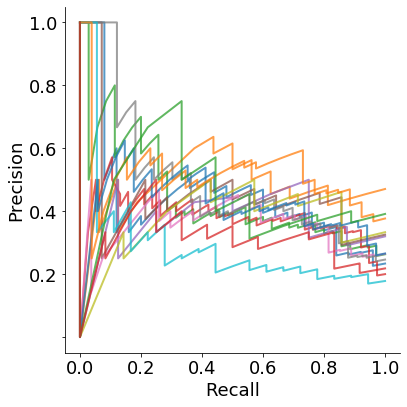

In [31]:
font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(6,6))
for cl in drug_classes:
    plt.plot(pr.recall[cl][1], pr.precision[cl][1], lw=2, alpha=0.75,
         label='%s (AP = %0.2f)' % (cl, pr.avprec[cl][1]))
    plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 13})
plt.legend([], frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-antagonism-vs-rest.pdf')

(0.0, 1.0, 0.0, 1.0)

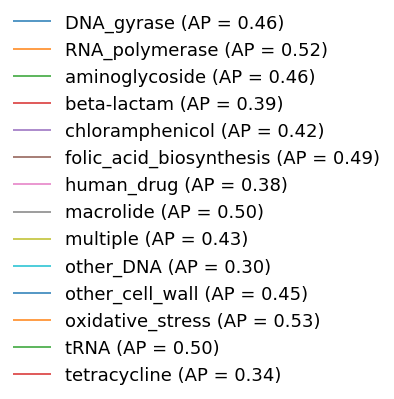

In [32]:
figsize = (6, 6)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
#fig_leg.savefig('Ecoli-legend-antag.pdf')

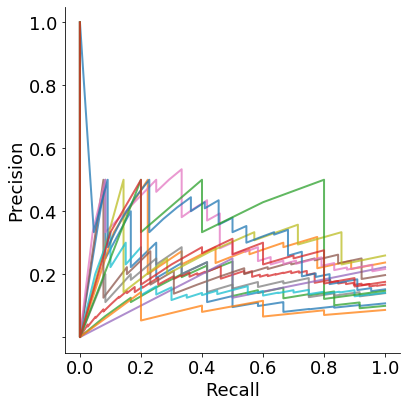

In [33]:
fig, ax = plt.subplots(figsize=(6,6))
for cl in drug_classes:
    plt.plot(pr.recall[cl][2], pr.precision[cl][2], lw=2, alpha=0.75,
         label='%s (AP = %0.2f)' % (cl, pr.avprec[cl][2]))
    plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend([], frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-synergy-vs-rest.pdf')

(0.0, 1.0, 0.0, 1.0)

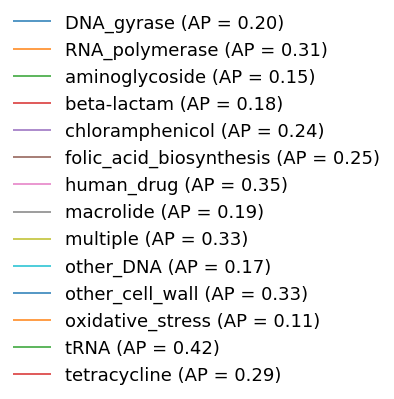

In [34]:
figsize = (6, 6)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
#fig_leg.savefig('Ecoli-legend-synergy.pdf')

Add only mean average precision:

In [35]:
preds_ = (pd.concat(pr.predicted).
                  reset_index().
                  rename(columns={"level_0": "cvfold"}).
                  drop(columns=['level_1']))

In [36]:
y_gt = targets.loc[:, ['comb', 'type']]
y_gt['syn'] = 0
y_gt['ant'] = 0
y_gt.loc[y_gt.type == 1,'ant'] = 1
y_gt.loc[y_gt.type == 2,'syn'] = 1

In [37]:
pred_vs_true = pd.merge(preds_, y_gt, on='comb')

In [38]:
pred_vs_true = pred_vs_true[np.isin(pred_vs_true.cvfold, drug_classes)]

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# A "micro-average": quantifying score on all classes jointly
prec_micro, recall_micro, _ = precision_recall_curve(pred_vs_true['ant'].values,
                                                    pred_vs_true['prob_ant'].values)
ap_micro = average_precision_score(pred_vs_true['ant'].values,
                                   pred_vs_true['prob_ant'].values,
                                   average="micro")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


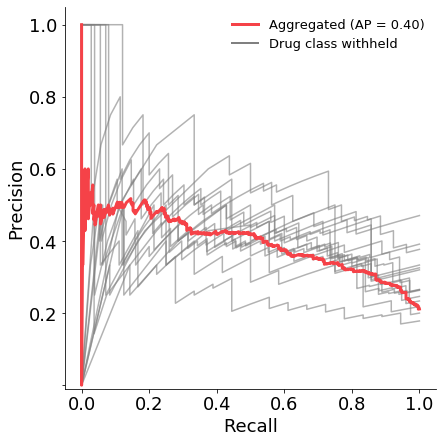

In [40]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in drug_classes:
    plt.plot(pr.recall[cl][1], pr.precision[cl][1],
             color='grey', lw=1.5, alpha=0.6)
    plt.xlim([-0.05, 1.05])
plt.plot(recall_micro, prec_micro,
        label='Aggregated (AP = {0:0.2f})'
               ''.format(ap_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.ylim([-0.01, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
plt.legend(handles=handles, loc='upper right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-antagonism-vs-rest-grey.pdf')

In [41]:
# A "micro-average": quantifying score on all classes jointly
prec_micro, recall_micro, _ = precision_recall_curve(pred_vs_true['syn'].values,
                                                    pred_vs_true['prob_syn'].values)
ap_micro = average_precision_score(pred_vs_true['syn'].values,
                                   pred_vs_true['prob_syn'].values,
                                   average="micro")

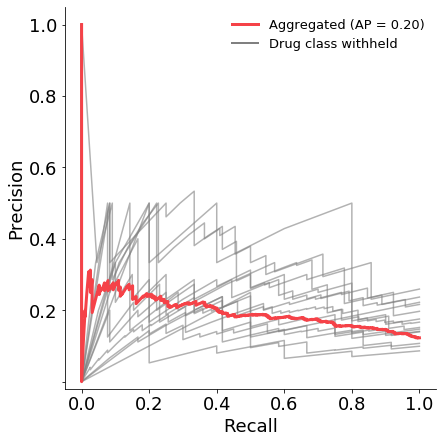

In [42]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in drug_classes:
    plt.plot(pr.recall[cl][2], pr.precision[cl][2],
            color='grey', lw=1.5, alpha=0.6)
    plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_micro, prec_micro,
        label='Aggregated (AP = {0:0.2f})'
               ''.format(ap_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.ylim([-0.02, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.title(title)
plt.legend(handles=handles, loc='upper right',
           prop={"size": 13},
            #bbox_to_anchor=(1.2,0.8),
          frameon=False)
#plt.legend([], frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-synergy-vs-rest-grey.pdf')

Plot ROC curves:

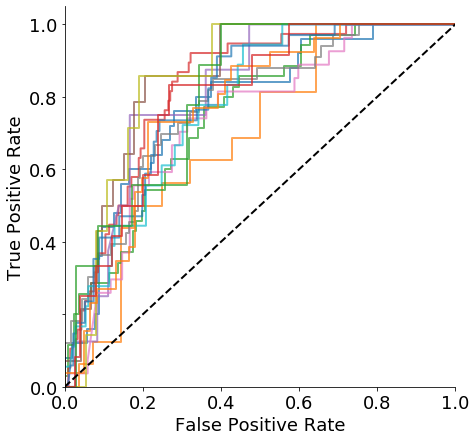

In [43]:
fig, ax = plt.subplots(figsize=(7,7))
for cl in drug_classes:
    plt.plot(pr.fpr[cl][1], pr.tpr[cl][1], lw=2, alpha=0.7,
             label='{0} (area = {1:0.2f})'
             ''.format(cl, pr.auc[cl][1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend([], frameon=False)
#plt.savefig('Ecoli-ROC-antagonism-vs-rest.pdf')

(0.0, 1.0, 0.0, 1.0)

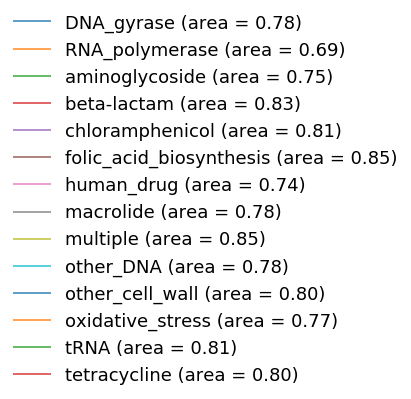

In [44]:
figsize = (6, 6)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
#fig_leg.savefig('Ecoli-ROC-legend-antag.pdf')

ROC curves for synergy vs rest:

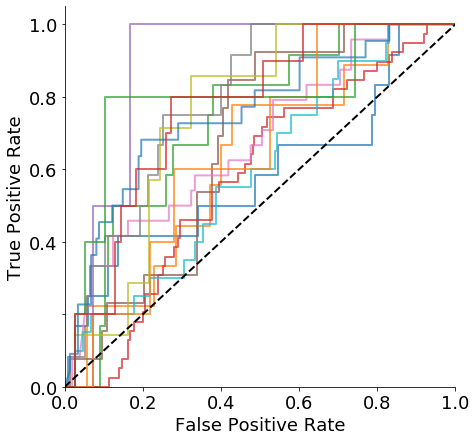

In [45]:
fig, ax = plt.subplots(figsize=(7,7))
for cl in drug_classes:
    plt.plot(pr.fpr[cl][2], pr.tpr[cl][2], lw=2, alpha=0.7,
             label='{0} (area = {1:0.2f})'
             ''.format(cl, pr.auc[cl][2]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend([], frameon=False)
#plt.savefig('Ecoli-ROC-synergy-vs-rest.pdf')

(0.0, 1.0, 0.0, 1.0)

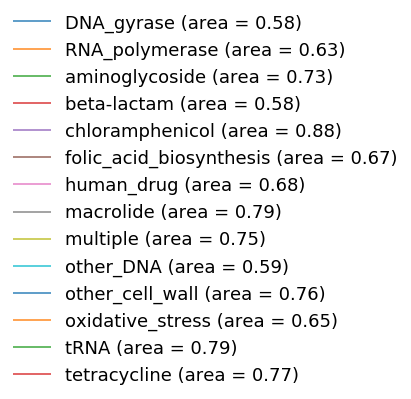

In [46]:
figsize = (6, 6)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
#fig_leg.savefig('Ecoli-ROC-legend-syn.pdf')

In [47]:
fpr_micro, tpr_micro, _ = roc_curve(pred_vs_true['ant'].values,
                                                    pred_vs_true['prob_ant'].values)
roc_auc_micro = auc(fpr_micro, tpr_micro)

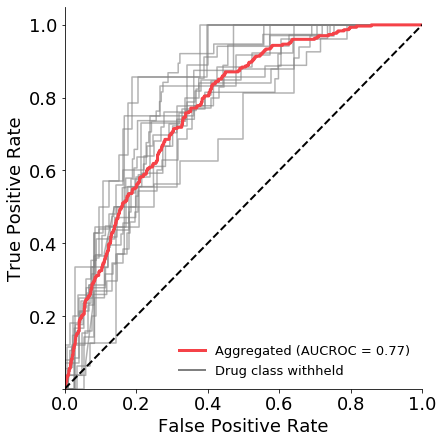

In [48]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in drug_classes:
    plt.plot(pr.fpr[cl][1], pr.tpr[cl][1],
             color='grey', lw=1.5, alpha=0.6)
plt.plot(fpr_micro, tpr_micro,
        label='Aggregated (AUCROC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(handles=handles, loc='lower right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-ROC-antagonism-vs-rest-grey.pdf')

In [49]:
fpr_micro, tpr_micro, _ = roc_curve(pred_vs_true['syn'].values,
                                                    pred_vs_true['prob_syn'].values)
roc_auc_micro = auc(fpr_micro, tpr_micro)

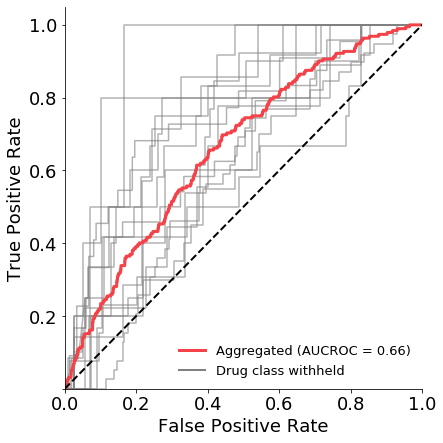

In [50]:
fig, ax = plt.subplots(figsize=(6.5,6.5))
for cl in drug_classes:
    plt.plot(pr.fpr[cl][2], pr.tpr[cl][2],
             color='grey', lw=1.5, alpha=0.6)
plt.plot(fpr_micro, tpr_micro,
        label='Aggregated (AUCROC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='#f54248', linestyle='-', linewidth=3)

handles, labels = ax.get_legend_handles_labels()
patch = Line2D([0], [0], color='grey', linewidth=2, linestyle="-",
               label='Drug class withheld')
handles.append(patch) 
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#ax.xaxis.get_major_ticks()[0].label1.set_visible(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
plt.legend(handles=handles, loc='lower right', prop={"size": 13},
          frameon=False)
plt.tight_layout()
#plt.savefig('Ecoli-ROC-synergy-vs-rest-grey.pdf')

## Train the Classifier with Cross-Validated Hyperparameters

In [51]:
Xtrain = X_onehot
ytrain = y

In [52]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf = OneVsRestClassifier(RandomForestClassifier(bootstrap=True,
                                                max_features='sqrt',
                                                **param_dict,
                                                random_state=2305,
                                              n_jobs=-1))

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.3,
                                                    random_state=2305)

In [55]:
clf = clf.fit(X_train, y_train)

In [56]:
probas_ = clf.predict_proba(X_val)

Plot precision-recall for the training set:

In [57]:
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
thresh = dict()
average_precision = dict()

In [58]:
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], probas_[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_val[:, i],
                                                        probas_[:, i])
    average_precision[i] = average_precision_score(y_val[:, i], probas_[:, i])


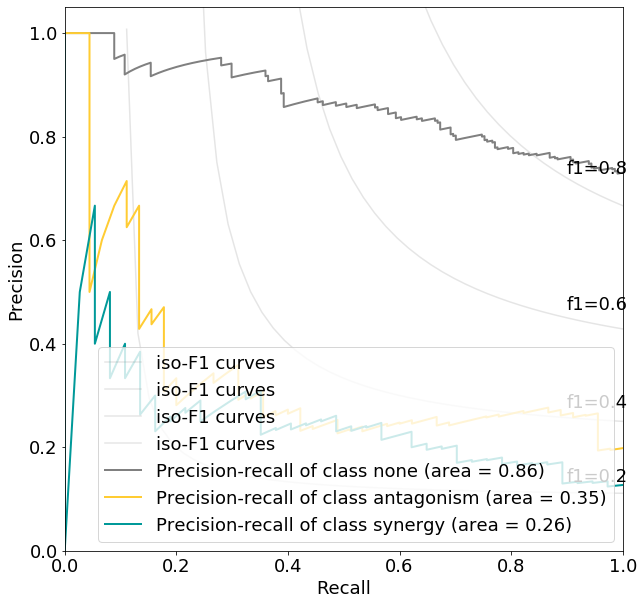

In [59]:
from itertools import cycle
class_names = ['none', 'antagonism', 'synergy']
colors = cycle(['#808080','#FFCC33', '#009999'])


plt.figure(figsize=(10,10))
f_scores = np.linspace(0.2, 0.8, num=4)

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y_ = f_score * x / (2 * x - f_score)
    plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.2,
             label='iso-F1 curves')
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

In [60]:
from sklearn.calibration import calibration_curve
fraction_of_positives = dict()
mean_predicted_value = dict()
for i in range(n_classes):
    proba_val = clf.predict_proba(X_val)[:, i]
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_val[:,i],
                                                                proba_val,
                                                                n_bins=4)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


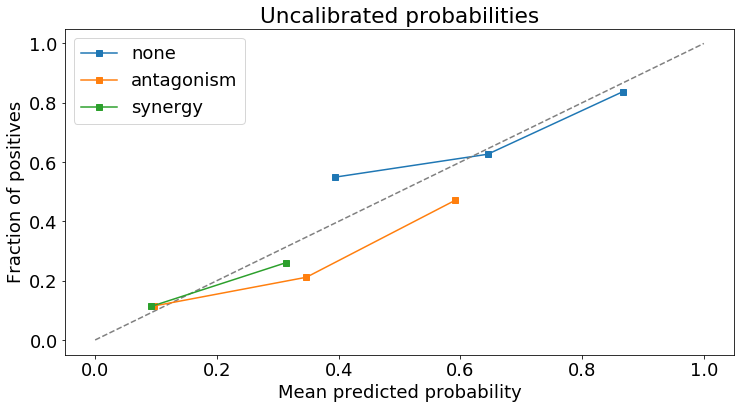

In [61]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value[0], fraction_of_positives[0], 's-', label='none')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(mean_predicted_value[1], fraction_of_positives[1], 's-', label='antagonism')
plt.plot(mean_predicted_value[2], fraction_of_positives[2], 's-', label='synergy')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Uncalibrated probabilities')
plt.legend()

In [62]:
from sklearn.calibration import CalibratedClassifierCV

In [63]:
fraction_of_positives = dict()
mean_predicted_value = dict()
for i in range(n_classes):
    #proba_val = clf.predict_proba(X_val)[:, i]
    clf_calib = CalibratedClassifierCV(clf.estimators_[i], cv=5, method='sigmoid')
    proba_val = clf_calib.fit(X_train, y_train[:,i]).predict_proba(X_val)[:,1]
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_val[:,i],
                                                                proba_val,
                                                                n_bins=5)

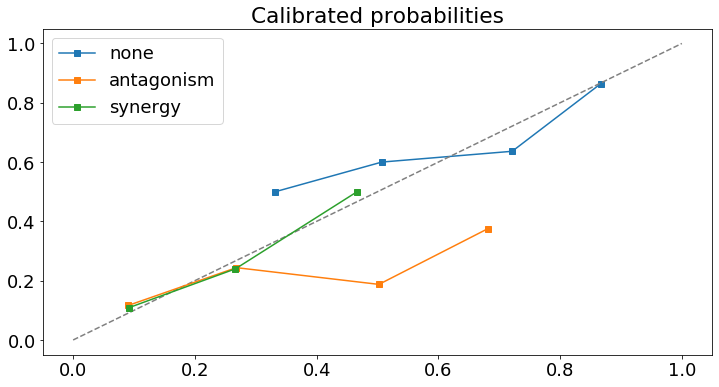

In [64]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value[0], fraction_of_positives[0], 's-', label='none')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(mean_predicted_value[1], fraction_of_positives[1], 's-', label='antagonism')
plt.plot(mean_predicted_value[2], fraction_of_positives[2], 's-', label='synergy')
plt.title('Calibrated probabilities')
plt.legend()

Somehow calibrated probabilities are worse than the "uncalibrated" ones.

## Generate Predictions on the Test Set

In [65]:
X_drugs = pd.read_csv('../data/chemgenetics/nichols_testset_binarized.csv', index_col=0)

In [66]:
X_drugs = X_drugs.iloc[:,np.where(np.isin(X_drugs.columns, gene_subset))[0]]

In [67]:
X_drugs.shape

(45, 391)

In [68]:
test_drugs = X_drugs.index.values

In [69]:
import itertools
combs_test = list(itertools.combinations(test_drugs, 2))
combs_test = np.array([i[0]+"_"+i[1] for i in combs_test])

In [70]:
len(combs_test)

990

In [71]:
X_test = pd.DataFrame([utl.get_comb_feat(X_drugs, c) for c in combs_test])

In [72]:
X_test = pd.get_dummies(X_test.astype('category'))

Pad some columns (as some are all zeros in the test set):

In [73]:
X_test.shape

(990, 992)

In [74]:
cols_pad = np.setdiff1d(Xtrain.columns, X_test.columns)

In [75]:
for col in cols_pad:
    X_test[col] = 0

In [76]:
X_test = X_test.loc[:,np.isin(X_test.columns, Xtrain.columns)]

In [77]:
X_test = X_test[Xtrain.columns]

In [78]:
np.all(X_test.columns == Xtrain.columns)

True

In [79]:
# without probability calibration
y_test_proba = clf.fit(Xtrain, ytrain).predict_proba(X_test)
antag = combs_test[y_test_proba[:,1] > 0.24]
syn = combs_test[y_test_proba[:,2] > 0.2]

In [80]:
prob_uncalibr = pd.DataFrame(y_test_proba, index=combs_test,
             columns=['none', 'antag', 'synergy'])

In [81]:
prob_uncalibr.to_csv('nichols_test_pred.csv')

In [82]:
prob_uncalibr.sort_values('antag', ascending=False).iloc[:30,:]

,none,antag,synergy
Chir090_Pms,0.576832,0.400683,0.265874
Ethanol_Pms,0.595862,0.361035,0.231147
Acriflavine_Pms,0.629751,0.358188,0.190038
Ethanol_Sds,0.549287,0.337977,0.185013
Chir090_Glufosfomycin,0.590858,0.334515,0.213461
Dibucaine_Streptonigrin,0.558488,0.327205,0.189896
Ethanol_Glufosfomycin,0.637024,0.324957,0.180377
Ethidiumbromide_Pms,0.522899,0.323396,0.211400
Cefoxitin_Pms,0.557249,0.319690,0.277608
Sds_Streptonigrin,0.564752,0.317353,0.159244


In [83]:
prob_uncalibr.sort_values('synergy', ascending=False).iloc[:30,:]

,none,antag,synergy
Cefoxitin_Ceftazidime,0.549638,0.267924,0.345361
Norfloxacin_Sds,0.575342,0.275935,0.344756
Cholate_Sds,0.516437,0.278222,0.342707
Ampicillin_Cholate,0.517368,0.162664,0.333236
Deoxycholate_Sds,0.617774,0.274695,0.326287
Azidothymidine_Sds,0.578661,0.234479,0.319738
Sds_Taurocholate,0.489535,0.297974,0.319424
Chir090_Ethanol,0.593673,0.308712,0.315541
Ethidiumbromide_Sds,0.513750,0.290606,0.313355
Cefoxitin_Cholate,0.535612,0.273738,0.312084


In [84]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=6)

In [85]:
# with calibration
probs = dict()
for i in range(n_classes):
    clf_calib = CalibratedClassifierCV(clf.estimators_[i], cv=skf, method='isotonic')
    probs[i] = clf_calib.fit(Xtrain, ytrain[:,i]).predict_proba(X_test)

In [86]:
antag = combs_test[probs[1][:,1] > 0.25]
syn = combs_test[probs[2][:,1] > 0.2]
not_none = combs_test[probs[0][:,1] < 0.6]

In [87]:
np.setdiff1d(antag, syn)

array(['Ampicillin_Chir090', 'Cefoxitin_Chlorpromazine',
       'Cefoxitin_Cisplatin', 'Cefoxitin_Hydroxyurea',
       'Cefoxitin_Streptonigrin', 'Chir090_Chlorpromazine',
       'Chir090_Peroxide', 'Chir090_Propidiumiodide',
       'Chlorpromazine_Dibucaine', 'Cisplatin_Dibucaine',
       'Cisplatin_Ethanol', 'Cisplatin_Pms', 'Dibucaine_Glufosfomycin',
       'Dibucaine_Hydroxyurea', 'Dibucaine_Mms', 'Dibucaine_Peroxide',
       'Dibucaine_Pms', 'Dibucaine_Streptonigrin',
       'Dibucaine_Tunicamycin', 'Ethanol_Nigericin', 'Ethanol_Pms',
       'Ethanol_Propidiumiodide', 'Ethanol_Streptonigrin',
       'Ethanol_Tunicamycin', 'Ethidiumbromide_Pms', 'Nalidixicacid_Pms',
       'Norfloxacin_Pms'], dtype='<U31')

In [88]:
np.setdiff1d(syn, antag)

array(['Acriflavine_Cefoxitin', 'Acriflavine_Chir090',
       'Acriflavine_Ethanol', 'Actinomycin D_Cefoxitin',
       'Actinomycin D_Ceftazidime', 'Actinomycin D_Dibucaine',
       'Actinomycin D_Ethanol', 'Actinomycin D_Sds',
       'Actinomycin D_Taurocholate', 'Ampicillin_Azidothymidine',
       'Ampicillin_Bile', 'Ampicillin_Carbenicillin',
       'Ampicillin_Cefoxitin', 'Ampicillin_Ceftazidime',
       'Ampicillin_Cholate', 'Ampicillin_Deoxycholate',
       'Ampicillin_Ethidiumbromide', 'Ampicillin_Norfloxacin',
       'Ampicillin_Sds', 'Ampicillin_Taurocholate', 'Azidothymidine_Bile',
       'Azidothymidine_Cefoxitin', 'Azidothymidine_Ceftazidime',
       'Azidothymidine_Cholate', 'Azidothymidine_Dibucaine',
       'Azidothymidine_Ethanol', 'Azidothymidine_Ethidiumbromide',
       'Azidothymidine_Norfloxacin', 'Azidothymidine_Sds',
       'Azidothymidine_Taurocholate', 'Bile_Cefoxitin',
       'Bile_Ceftazidime', 'Bile_Cholate', 'Bile_Dibucaine',
       'Bile_Epinephrine', 'Bile

In [89]:
np.intersect1d(antag, syn)

array(['Ampicillin_Dibucaine', 'Carbenicillin_Dibucaine',
       'Cefoxitin_Ethanol', 'Cefoxitin_Norfloxacin', 'Cefoxitin_Pms',
       'Cefoxitin_Taurocholate', 'Ceftazidime_Chir090',
       'Ceftazidime_Dibucaine', 'Ceftazidime_Ethanol',
       'Chir090_Norfloxacin', 'Chir090_Pms', 'Chir090_Sds',
       'Cholate_Dibucaine', 'Cholate_Pms', 'Deoxycholate_Dibucaine',
       'Dibucaine_Norfloxacin', 'Dibucaine_Sds', 'Dibucaine_Taurocholate',
       'Ethanol_Nalidixicacid', 'Ethanol_Sds', 'Pms_Sds'], dtype='<U31')

In [90]:
# possibly not 'none'
not_none = combs_test[y_test_proba[:,0] < 0.6]

In [91]:
np.intersect1d(antag, not_none).shape

(34,)

In [92]:
np.intersect1d(syn, not_none).shape

(81,)

In [93]:
np.intersect1d(antag, not_none)

array(['Ampicillin_Dibucaine', 'Carbenicillin_Dibucaine',
       'Cefoxitin_Chlorpromazine', 'Cefoxitin_Cisplatin',
       'Cefoxitin_Ethanol', 'Cefoxitin_Norfloxacin', 'Cefoxitin_Pms',
       'Cefoxitin_Taurocholate', 'Ceftazidime_Chir090',
       'Ceftazidime_Dibucaine', 'Ceftazidime_Ethanol',
       'Chir090_Chlorpromazine', 'Chir090_Peroxide', 'Chir090_Pms',
       'Chir090_Sds', 'Cholate_Dibucaine', 'Cholate_Pms',
       'Cisplatin_Ethanol', 'Deoxycholate_Dibucaine',
       'Dibucaine_Glufosfomycin', 'Dibucaine_Mms',
       'Dibucaine_Norfloxacin', 'Dibucaine_Pms', 'Dibucaine_Sds',
       'Dibucaine_Streptonigrin', 'Dibucaine_Taurocholate',
       'Dibucaine_Tunicamycin', 'Ethanol_Pms', 'Ethanol_Sds',
       'Ethanol_Streptonigrin', 'Ethanol_Tunicamycin',
       'Ethidiumbromide_Pms', 'Norfloxacin_Pms', 'Pms_Sds'], dtype='<U31')

In [94]:
np.intersect1d(syn, not_none)

array(['Acriflavine_Cefoxitin', 'Acriflavine_Chir090',
       'Acriflavine_Ethanol', 'Actinomycin D_Cefoxitin',
       'Ampicillin_Cefoxitin', 'Ampicillin_Ceftazidime',
       'Ampicillin_Cholate', 'Ampicillin_Dibucaine',
       'Ampicillin_Ethidiumbromide', 'Ampicillin_Norfloxacin',
       'Ampicillin_Taurocholate', 'Azidothymidine_Cefoxitin',
       'Azidothymidine_Cholate', 'Azidothymidine_Dibucaine',
       'Azidothymidine_Ethidiumbromide', 'Azidothymidine_Sds',
       'Azidothymidine_Taurocholate', 'Bile_Cefoxitin', 'Bile_Cholate',
       'Bile_Dibucaine', 'Bile_Ethidiumbromide', 'Bile_Taurocholate',
       'Carbenicillin_Cefoxitin', 'Carbenicillin_Dibucaine',
       'Carbenicillin_Ethanol', 'Cefoxitin_Ceftazidime',
       'Cefoxitin_Chir090', 'Cefoxitin_Cholate', 'Cefoxitin_Deoxycholate',
       'Cefoxitin_Dibucaine', 'Cefoxitin_Ethanol',
       'Cefoxitin_Ethidiumbromide', 'Cefoxitin_Norfloxacin',
       'Cefoxitin_Pms', 'Cefoxitin_Radicicol', 'Cefoxitin_Sds',
       'Cefoxitin_